# Dynamical Modeling

Here, we use the generalized dynamical model to solve the full transcriptional dynamics. 

That yields several additional insights such as latent time and identification of putative driver genes.

As in the previous tutorial, it is illustratively applied to endocrine development in the [pancreas](https://scvelo.readthedocs.io/scvelo.datasets.pancreas).

In [ ]:
import scvelo as scv
scv.logging.print_version()
import scanpy as sc
import os
os.chdir("/data/home/wx/scislets") 
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization


In [ ]:
%%R
library ('Seurat')
panc<-readRDS('processed/annotation_adata_out.rds')

In [4]:
%%R
cell_name <- Cells(panc)
for(i in 1:length(cell_name)){                                                
if(strsplit(cell_name[i],'-')[[1]][2]=='CT'){
cell_name[i] <- paste('anno_decon_CB_R8BK3-',strsplit(cell_name[i],'-')[[1]][1],sep='')
}
else if(strsplit(cell_name[i],'-')[[1]][2]=='ZP'){
cell_name[i] <- paste('anno_decon_CB_1POTN-',strsplit(cell_name[i],'-')[[1]][1],sep='')
}
else if(strsplit(cell_name[i],'-')[[1]][2]=='ANS'){
cell_name[i] <- paste('anno_decon_CB_063JO-',strsplit(cell_name[i],'-')[[1]][1],sep='')
}
}

In [5]:
%%R -o cell_name_merge
cell_name_merge <- as.data.frame(Cells(panc))
cell_name_merge$cell_name <- cell_name

In [6]:
adata = sc.read_h5ad(
    filename="processed/annotation_adata_out.h5ad",
)

adata.X = adata.layers ['counts'].astype(int).copy()
adata.raw = adata


In [7]:
adata.obs = pd.merge(left=adata.obs,         
                          right=cell_name_merge,        
                          left_on=adata.obs.index,  
                          right_on='Cells(panc)',   
                          how='left') 

In [8]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,...,leiden,leiden_res0_25,leiden_res0_5,leiden_res0_8,leiden_res1,size_factors,leiden_0_8,manual_celltype_annotation,Cells(panc),cell_name
0,CT,63408.0,9465,9465,9.155462,63408.0,11.057361,12.224010,2956.0,7.991931,...,5,0,0,0,5,1.328791,5,Immature Beta,CELL17_N2-CT,anno_decon_CB_R8BK3-CELL17_N2
1,CT,43684.0,8465,8465,9.043813,43684.0,10.684760,12.622470,1029.0,6.937314,...,1,0,0,0,1,1.252417,0,EC,CELL22_N2-CT,anno_decon_CB_R8BK3-CELL22_N2
2,CT,38475.0,7735,7735,8.953640,38475.0,10.557790,14.606888,1609.0,7.383989,...,0,1,1,1,0,1.251071,1,Beta,CELL28_N2-CT,anno_decon_CB_R8BK3-CELL28_N2
3,CT,74011.0,9582,9582,9.167746,74011.0,11.211983,16.923160,4052.0,8.307213,...,4,0,0,0,4,1.294068,3,EC,CELL32_N3-CT,anno_decon_CB_R8BK3-CELL32_N3
4,CT,50981.0,9054,9054,9.111072,50981.0,10.839228,12.655695,3050.0,8.023225,...,8,4,4,4,8,1.392794,5,Immature Beta,CELL36_N4-CT,anno_decon_CB_R8BK3-CELL36_N4


In [9]:
adata.obs.index = adata.obs.cell_name.copy()
del adata.obs['cell_name']
del adata.obs['Cells(panc)']

In [10]:
adata = adata[adata.obs.batch=="CT", :].copy()

In [ ]:
ldata = scv.read('data/CT/output/velocity/anno_decon_CB_R8BK3.loom', cache=True)
ldata.obs.head()

In [12]:
ldata.obs = ldata.obs.rename(index = lambda x: x.replace(':', '-').replace('x', ''))
ldata.obs_names_make_unique()
ldata.obs.head()

""
CellID
anno_decon_CB_R8BK3-CELL10174_N1
anno_decon_CB_R8BK3-CELL10727_N1
anno_decon_CB_R8BK3-CELL10754_N1
anno_decon_CB_R8BK3-CELL10422_N1
anno_decon_CB_R8BK3-CELL1082_N2


In [13]:
adata = scv.utils.merge(adata, ldata)

In [14]:
adata = adata [ adata.obs ['manual_celltype_annotation'].isin (['Beta', 'Immature Beta','Stressed Beta','Alpha','EC'])].copy()

In [15]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

Filtered out 7965 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


/tmp/ipykernel_3934769/2386943043.py:4: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, enforce=True)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 83 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


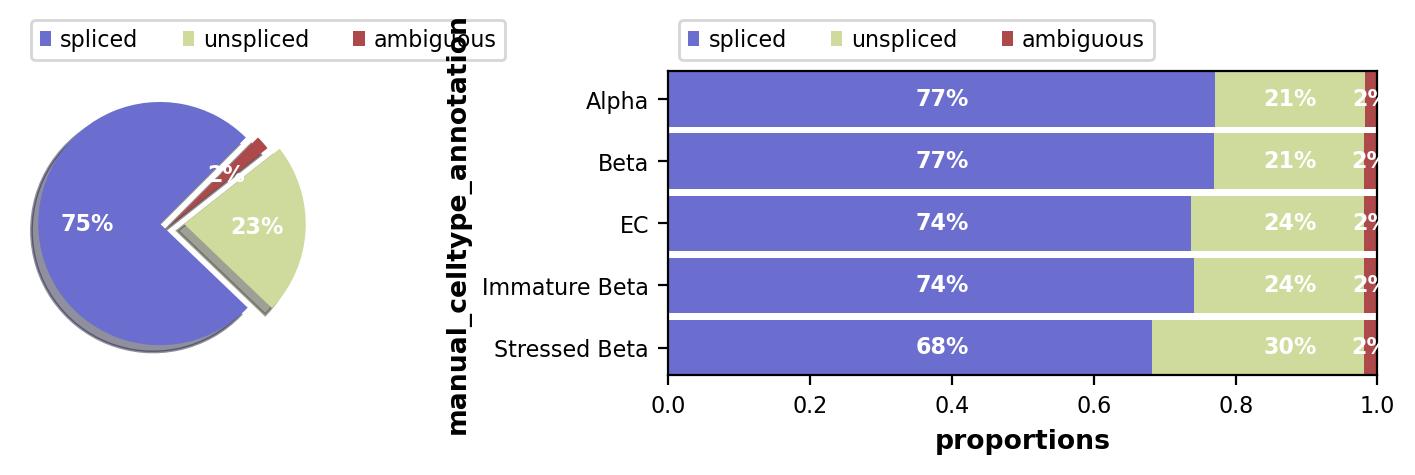

In [17]:
scv.pl.proportions(adata, groupby='manual_celltype_annotation')

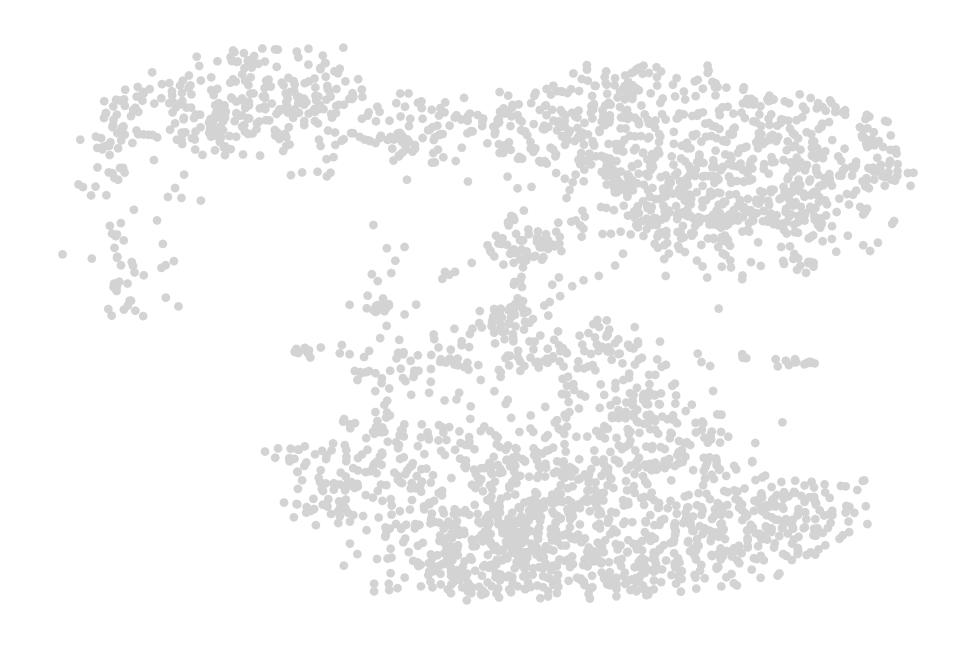

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [18]:
sc.pl.umap(adata, frameon=False, legend_loc='on data')
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

recovering dynamics (using 8/128 cores)


  0%|          | 0/734 [00:00<?, ?gene/s]

    finished (0:03:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)


  0%|          | 0/3062 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

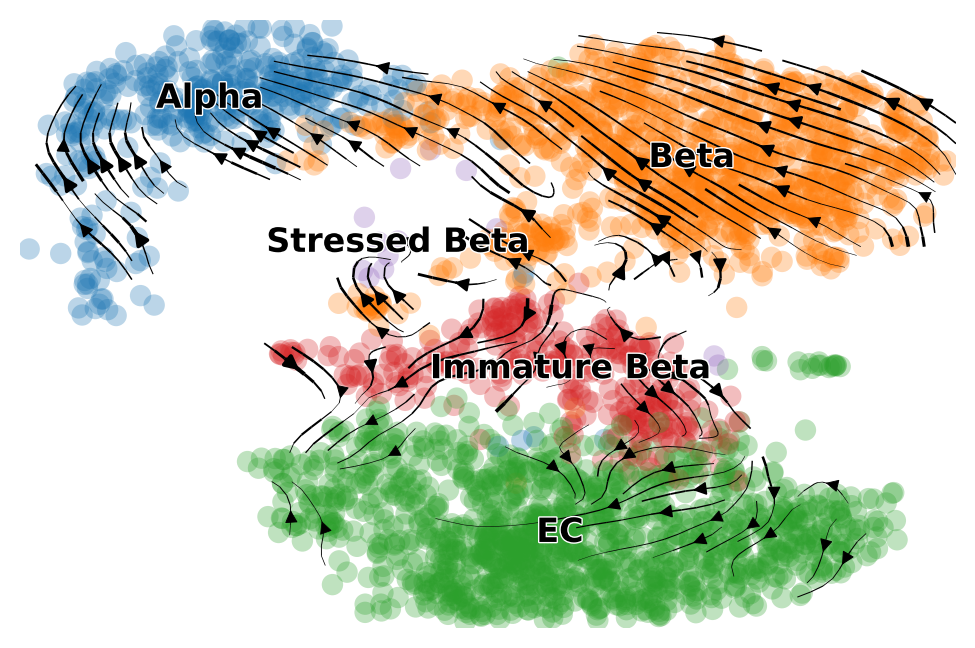

In [19]:
scv.tl.recover_dynamics(adata, n_jobs=8) #separately... (!!) takes around 4 m: 15:15-18
scv.tl.velocity(adata, mode="dynamical") #separately as a oneliner, not in the 'cell'...
scv.tl.velocity_graph(adata) #separately... and the note in the next line the basis as 'umap' and not 'X_umap'
scv.pl.velocity_embedding_stream(adata, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color ='manual_celltype_annotation' )

/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

saving figure to file ./figures/scvelo_CT_PAGA_VELOCITY_GRAPH_dynamical_arrow.svg


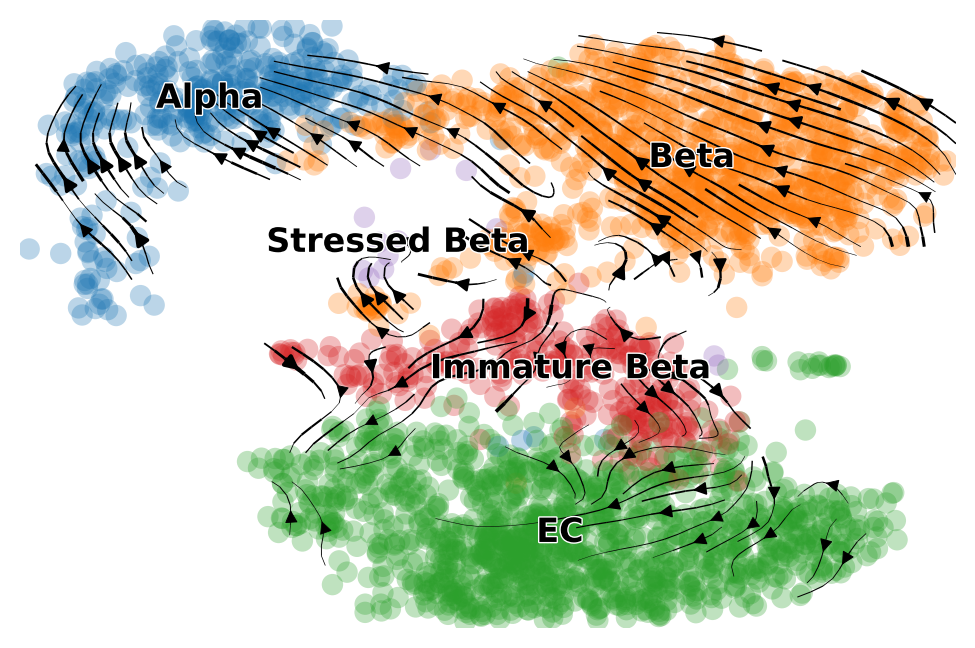

In [21]:
scv.pl.velocity_embedding_stream(adata, basis="umap", legend_fontsize=12, 
                                 title="", smooth=0.8, min_mass=4, 
                                 color ='manual_celltype_annotation',
                                 save='CT_PAGA_VELOCITY_GRAPH_dynamical_arrow.svg')

In [20]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index

In [21]:
print(top_genes)

Index(['TFPI2', 'COL5A2', 'LMX1A', 'AFP', 'DPP4', 'DDC', 'SLC7A2', 'CHODL',
       'KCNJ3', 'ERO1B',
       ...
       'SEPTIN6', 'ENOX2', 'IGSF1', 'FIRRE', 'HPRT1', 'HTATSF1', 'FGF13',
       'HMGB3', 'CCNQ', 'NLGN4Y'],
      dtype='object', length=1917)


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

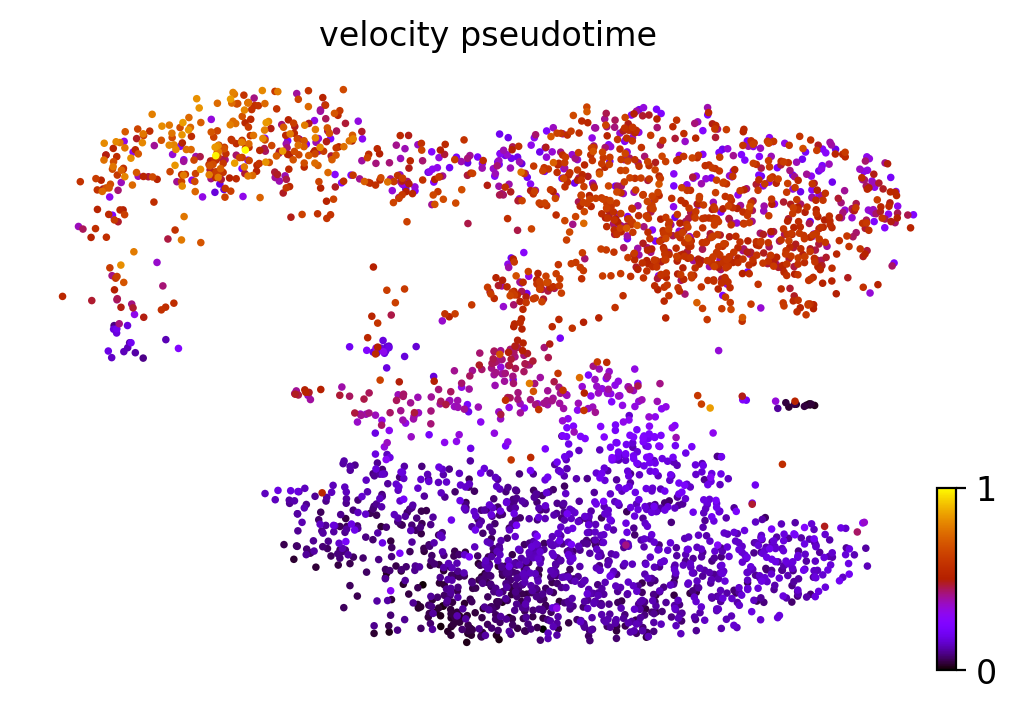

In [22]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [23]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='manual_celltype_annotation')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/core/_anndata.py:245: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(data.obs[key])


,Alpha,Beta,EC,Immature Beta,Stressed Beta
Alpha,0,0,0,0,0
Beta,0.13,0,0,0,0
EC,0,0,0,0.33,0
Immature Beta,0.12,0,0,0,0
Stressed Beta,0,0.12,0,0,0


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

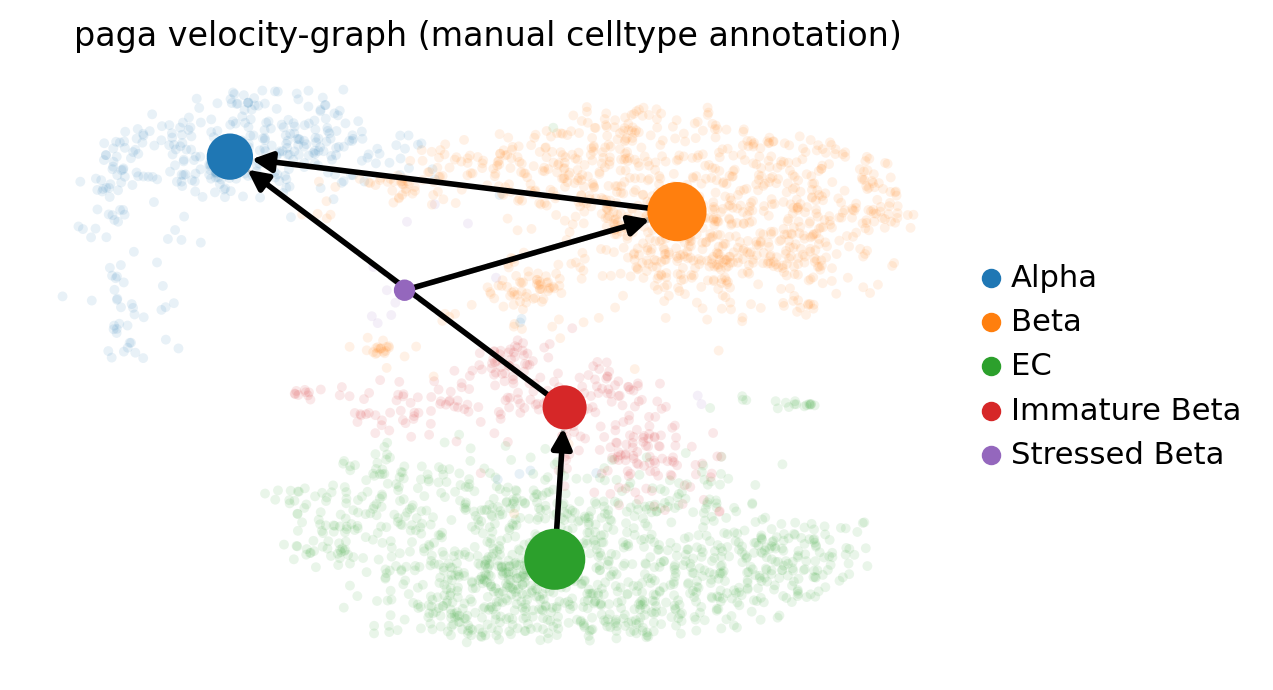

In [24]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

####steady_state

recovering dynamics (using 8/128 cores)


  0%|          | 0/570 [00:00<?, ?gene/s]

    finished (0:01:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)


  0%|          | 0/3062 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


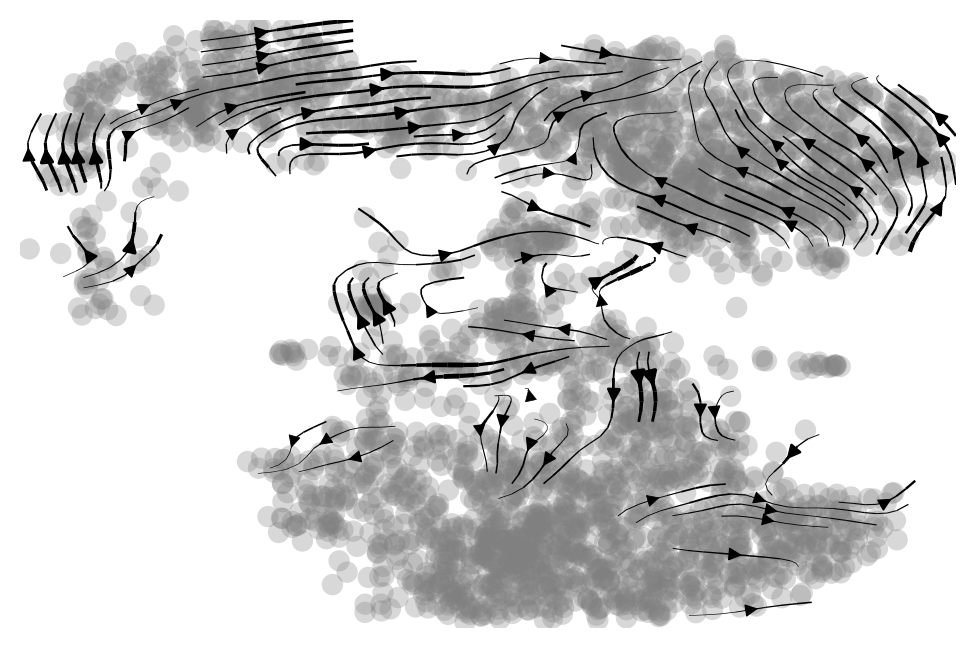

In [25]:
scv.tl.recover_dynamics(adata, n_jobs=8) #separately... (!!) takes around 4 m: 15:15-18
scv.tl.velocity(adata, mode="steady_state") #separately as a oneliner, not in the 'cell'...
scv.tl.velocity_graph(adata) #separately... and the note in the next line the basis as 'umap' and not 'X_umap'
scv.pl.velocity_embedding_stream(adata, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4)

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

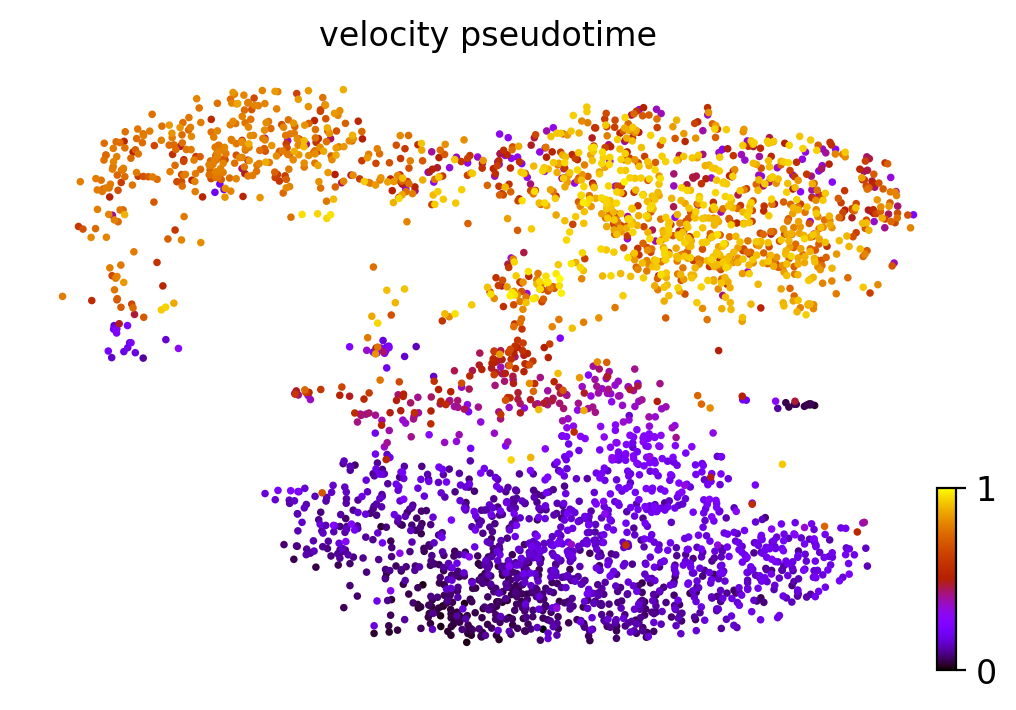

In [26]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [27]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='manual_celltype_annotation')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/core/_anndata.py:245: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(data.obs[key])


,Alpha,Beta,EC,Immature Beta,Stressed Beta
Alpha,0,0,0,0,0
Beta,0,0,0,0,0
EC,0,0,0,0.24,0
Immature Beta,0.13,0.11,0,0,0
Stressed Beta,0,0.27,0,0,0


/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/data/home/wx/miniconda3/envs/scvelo/lib/python3.9/site

saving figure to file ./figures/scvelo_CT_PAGA_VELOCITY_GRAPH_dynamical.pdf


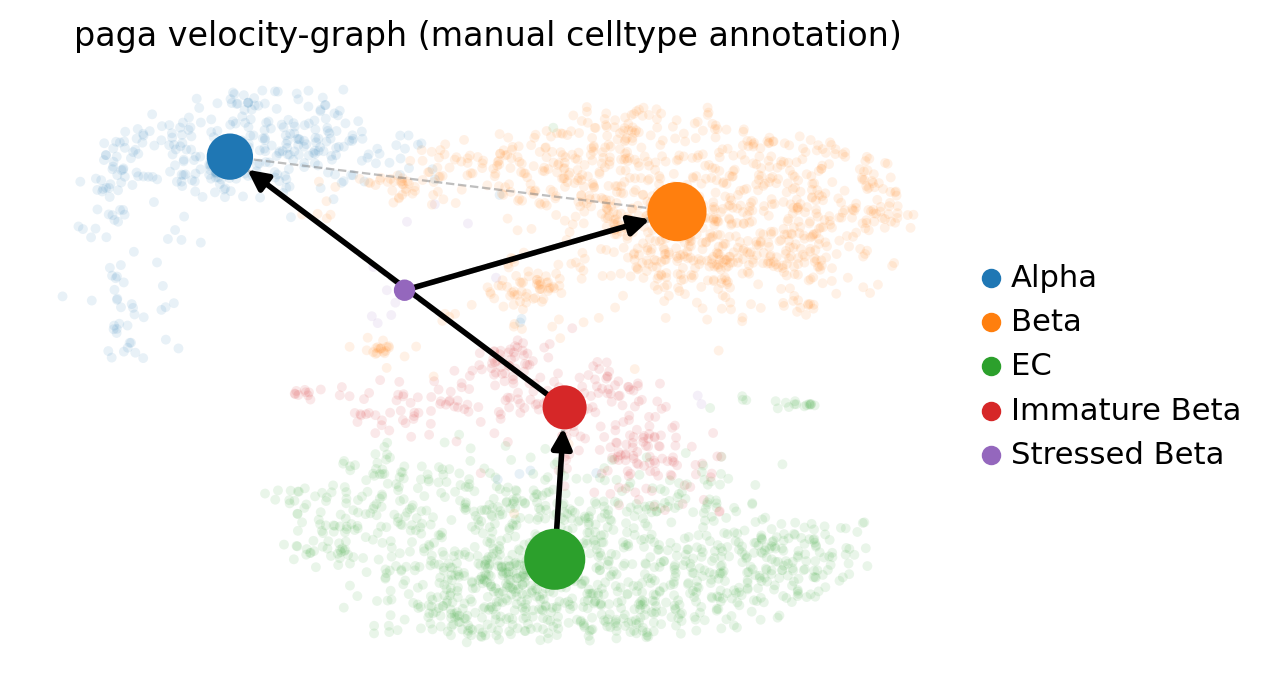

In [30]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5,
           save='CT_PAGA_VELOCITY_GRAPH_dynamical.pdf' )